# Import modules

In [1]:
#import general modules
import numpy as np
import io, sys, time, math, os.path, unittest, sys
import matplotlib.pyplot as plt
import pandas as pd

# Load files

In [2]:
#Todo: use sys commands to dynamically find in github folder
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/Dept_Interior_Data/'

file_name='NRRS_reservations_byVisitorOriginZip_AllYears.csv'
zip_origin_df=pd.read_csv(file_location+file_name)

file_name='NRRS_reservations_byFacilityName_AllYears.csv'
by_campground_df=pd.read_csv(file_location+file_name)

file_name='PPL_reservationdata.csv' #2.2gb --> very large
reservation_df=by_campground_df=pd.read_csv(file_location+file_name)


In [25]:
#load models
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/'
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
#distance_to_park_df[['D2NF_km','ZIP_CODE']]

In [4]:
#Census Data
file_location=github_folder+'raw_data/'

file_name='aggregate_income.csv'
income_df=pd.read_csv(file_location+file_name)

file_name='2010CensusPopulationData.csv'
racial_info_df=pd.read_csv(file_location+file_name)

#distance to 
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
distance_to_park_df[['D2NF_km','ZIP_CODE']]

file_name='education.csv'
education_df=pd.read_csv(file_location+file_name)
education_df.rename(columns={'zip code tabulation area': 'zip_code_tabulation_area'},inplace=True)
education_df.rename(columns={'B06009_001E': 'Total_reported_education_per_zip'},inplace=True)
education_df.rename(columns={'B06009_002E': 'Less_than_high_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_003E': 'High_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_004E': 'Some_college_or_associates_degree'},inplace=True)
education_df.rename(columns={'B06009_005E': 'Bachelor_degree'},inplace=True)
education_df.rename(columns={'B06009_006E': 'Graduate_or_professional_degree'},inplace=True)
education_df=education_df[['zip_code_tabulation_area','Less_than_high_school_graduate','High_school_graduate'
                ,'Some_college_or_associates_degree','Bachelor_degree','Graduate_or_professional_degree'
                ,'Total_reported_education_per_zip']]
#education_df

In [5]:
#drop the duplicate columns and use to merge
temp=reservation_df.drop_duplicates(subset = ' CustZip')
temp=temp[[' CustState',' CustCountry',' CustZip']]
temp[' CustZip']=pd.to_numeric(temp[' CustZip'], errors='coerce')

# Join dataframes

In [6]:
#join the dataframes
aggregate_df=pd.merge(zip_origin_df, racial_info_df, left_on = 'visitor_zip', right_on = 'Zip')
aggregate_df=pd.merge(aggregate_df,income_df,left_on='visitor_zip',right_on='zip code tabulation area')
#move the line below to higher up
aggregate_df.rename(columns={'Annual Aggregate Family Income': 'Annual_Aggregate_Family_Income'},inplace=True)
aggregate_df= pd.merge(aggregate_df,temp,left_on = 'visitor_zip', right_on = ' CustZip')
aggregate_df= pd.merge(aggregate_df,education_df,left_on='visitor_zip',right_on='zip_code_tabulation_area')
aggregate_df=pd.merge(aggregate_df,distance_to_park_df,left_on='visitor_zip',right_on='ZIP_CODE')

In [7]:
#rename columns without spaces
aggregate_df.rename(columns={' CustZip': 'CustZip'},inplace=True)
aggregate_df.rename(columns={' CustState': 'CustState'},inplace=True)
aggregate_df.rename(columns={' CustCountry': 'Custcountry'},inplace=True)
#aggregate_df.iloc[0]['Custcountry']

# Create new columns

In [8]:
#get the utilization_factors into the dataframe
aggregate_df['util_unique'] = pd.Series(
    (aggregate_df.sum_dur / aggregate_df.Population))
aggregate_df['util_days']= pd.Series(
    (aggregate_df.sum_persnight  / aggregate_df.Population))

In [9]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['sum_dur']\
    /float(aggregate_df.iloc[[0]]['Population'])),\
     float(aggregate_df.iloc[[0]]['util_unique']))

This 0.000754 should equal that 0.000754


In [10]:
#get the male/female breakdowns per visit per zip code
#using unique visits for the rest of these breakdowns!! (i.e. sum_dur)
aggregate_df['visits_female'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))
aggregate_df['visits_male'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))

In [11]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationFemale']\
    /float(aggregate_df.iloc[[0]]['Population']))\
    *float(aggregate_df.iloc[[0]]['sum_dur']),\
     float(aggregate_df.iloc[[0]]['visits_female']))

This 7.156058 should equal that 7.156058


In [12]:
#get the race breakdown per visit per zip code
aggregate_df['visits_RaceWhite'] = pd.Series(
    (aggregate_df.PopulationRaceWhite * aggregate_df.sum_dur))
aggregate_df['visits_RaceBlack'] = pd.Series(
    (aggregate_df.PopulationRaceBlack * aggregate_df.sum_dur))
aggregate_df['visits_Amerindian'] = pd.Series(
    (aggregate_df.PopulationAmerindian * aggregate_df.sum_dur))
aggregate_df['visits_RacePacific'] = pd.Series(
    (aggregate_df.PopulationRacePacific * aggregate_df.sum_dur))
aggregate_df['visits_RaceLatino'] = pd.Series(
    (aggregate_df.PopulationRaceLatino * aggregate_df.sum_dur))
aggregate_df['visits_RaceMulti'] = pd.Series(
    (aggregate_df.PopulationRaceMulti * aggregate_df.sum_dur))
aggregate_df['visits_RaceOther'] = pd.Series(
    (aggregate_df.PopulationRaceOther * aggregate_df.sum_dur))

In [13]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationRaceWhite']\
    *float(aggregate_df.iloc[[0]]['sum_dur'])),\
     float(aggregate_df.iloc[[0]]['visits_RaceWhite']))

This 0.060312 should equal that 0.060312


In [14]:
#scale the annual family aggregate income (which is per zip code)
#to individual families
aggregate_df['per_family_annual_income'] = pd.Series(
    (aggregate_df.Annual_Aggregate_Family_Income / aggregate_df.Households))

In [15]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['Annual_Aggregate_Family_Income']\
    /float(aggregate_df.iloc[[0]]['Households'])),\
     float(aggregate_df.iloc[[0]]['per_family_annual_income']))


This 16366.160920 should equal that 16366.160920


In [16]:
#get percent of people who are high school educated
aggregate_df['non_hs_educated'] = pd.Series(
    (aggregate_df.Less_than_high_school_graduate / aggregate_df.Total_reported_education_per_zip))

In [17]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[-1]]['Less_than_high_school_graduate']\
    /float(aggregate_df.iloc[[-1]]['Total_reported_education_per_zip'])),\
     float(aggregate_df.iloc[[-1]]['non_hs_educated']))

This 0.109489 should equal that 0.109489


# Trim data

In [20]:
#create the data to send to Cartos DB and use for the graphing
regression_df=aggregate_df[[
        'CustZip',
        'CustState',
        'per_family_annual_income',
        'non_hs_educated',
        'PopulationRaceWhite',
        'D2NF_km',
        'util_days']]
#rename the distance column
regression_df.rename(columns={'D2NF_km': 'Dist_to_park'},inplace=True)
#print random entry
regression_df.iloc[81]

CustZip                          1037
CustState                          MA
per_family_annual_income        77550
non_hs_educated             0.0456522
PopulationRaceWhite          0.958234
Dist_to_park                  32.4249
util_days                   0.0859189
Name: 81, dtype: object

# Save the trimmed datframe to database

In [21]:
#save the dataframe to a csv
file_location=github_folder + 'processed_data/'
file_name='test4.csv'
regression_df.to_csv(file_location+file_name, sep=',')

# Plot correlations

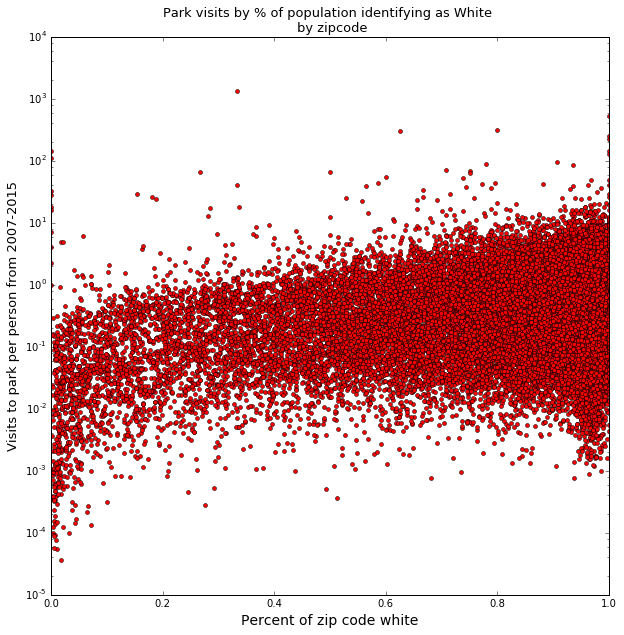

In [22]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['PopulationRaceWhite'],regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Percent of zip code white',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)

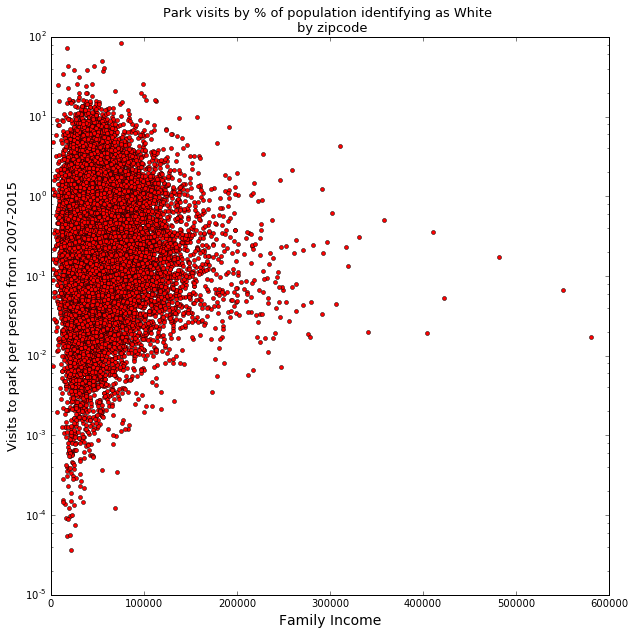

In [24]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['per_family_annual_income'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Family Income',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)